In [17]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

class SpectrumDataset:
    def __init__(self, db_path='spectra.db', limit=None):
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()
        self.limit = limit
        self.molecules = []
        self.spectra = []
        self.load_data()

    def load_data(self):
        # Get total number of molecules
        self.cursor.execute("SELECT COUNT(*) FROM Molecules WHERE state='gas'")
        n_molecules = self.cursor.fetchone()[0]
        print(f"Total number of gas-state molecules: {n_molecules}")

        # Fetch molecules
        query = '''
            SELECT m.id, m.title, m.names
            FROM Molecules m
            WHERE m.state = 'gas'
        '''
        if self.limit:
            query += f' LIMIT {self.limit}'
        
        self.cursor.execute(query)
        molecules = self.cursor.fetchall()

        # Fetch spectrum data for each molecule
        for mol_id, title, names in molecules:
            self.cursor.execute('''
                SELECT x, y FROM SpectrumData
                WHERE molecule_id = ?
                ORDER BY x
            ''', (mol_id,))
            spectrum_data = self.cursor.fetchall()
            
            if spectrum_data:
                x_values, y_values = zip(*spectrum_data)
                self.molecules.append((mol_id, title, names))
                self.spectra.append((np.array(x_values), np.array(y_values)))

        print(f"Loaded {len(self.molecules)} molecules with spectrum data")

    def __len__(self):
        return len(self.molecules)

    def __getitem__(self, idx):
        mol_id, title, names = self.molecules[idx]
        x_values, y_values = self.spectra[idx]
        return {
            'mol_id': mol_id,
            'title': title,
            'names': names,
            'x_values': x_values,
            'y_values': y_values
        }

    def __del__(self):
        self.conn.close()

# Create an instance of the dataset
dataset = SpectrumDataset(limit=10)  # Limit to 100 molecules for testing



OperationalError: no such column: state

In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import torch

class SpectrumDataset(torch.utils.data.Dataset):
    def __init__(self, db_path='final.db', limit=None):
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()
        self.limit = limit
        self.molecules = []
        self.spectra = []
        self.functional_groups = []
        self.load_data()

    def load_data(self):
        # Fetch molecules
        query = '''
            SELECT m.id, m.name, m.smiles
            FROM Molecules m
        '''
        if self.limit:
            query += f' LIMIT {self.limit}'
        
        self.cursor.execute(query)
        molecules = self.cursor.fetchall()

        # Fetch spectrum data and functional groups for each molecule
        for mol_id, name, smiles in molecules:
            self.cursor.execute('''
                SELECT wavelength, intensity FROM SpectrumData
                WHERE molecule_id = ?
                ORDER BY wavelength
            ''', (mol_id,))
            spectrum_data = self.cursor.fetchall()
            
            self.cursor.execute('''
                SELECT group_name, present FROM FunctionalGroups
                WHERE molecule_id = ?
            ''', (mol_id,))
            functional_group_data = self.cursor.fetchall()
            
            if spectrum_data and functional_group_data:
                x_values, y_values = zip(*spectrum_data)
                self.molecules.append((mol_id, name, smiles))
                self.spectra.append((np.array(x_values), np.array(y_values)))
                
                # Convert functional group data to tensor
                fg_tensor = torch.tensor([present for _, present in functional_group_data], dtype=torch.float32)
                self.functional_groups.append(fg_tensor)

        print(f"Loaded {len(self.molecules)} molecules with spectrum data and functional groups")

    def __len__(self):
        return len(self.molecules)

    def __getitem__(self, idx):
        mol_id, name, smiles = self.molecules[idx]
        x_values, y_values = self.spectra[idx]
        fg_tensor = self.functional_groups[idx]
        return {
            'mol_id': mol_id,
            'name': name,
            'smiles': smiles,
            'x_values': torch.tensor(x_values, dtype=torch.float32),
            'y_values': torch.tensor(y_values, dtype=torch.float32),
            'functional_groups': fg_tensor
        }

    def __del__(self):
        self.conn.close()

# Create an instance of the dataset
dataset = SpectrumDataset(limit=10)  # Limit to 10 molecules for testing


Loaded 10 molecules with spectrum data and functional groups


/tmp/ipykernel_15443/454945417.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wavelengths = np.array(wavelengths)
/tmp/ipykernel_15443/454945417.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  intensities = np.array(intensities)  # Ensure it's a numpy array


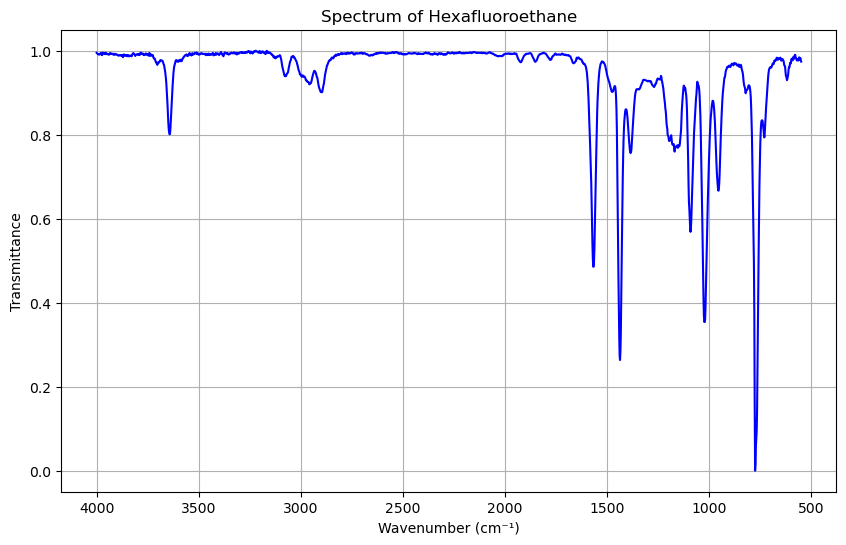

Hexafluoroethane
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.])


In [51]:
# Example usage: plot the first spectrum in the dataset
if len(dataset) > 0:
    first_spectrum = dataset[7]
    plot_spectrum(first_spectrum['x_values'], first_spectrum['y_values'], 
                  title=f"Spectrum of {first_spectrum['name']}")
    print(first_spectrum['name'])
    print(first_spectrum['functional_groups'])

else:
    print("No spectra found in the dataset.")


In [42]:
def plot_spectrum(wavelengths, intensities, title="Infrared Spectrum"):
    wavelengths = np.array(wavelengths)
    wavenumbers = wavelengths
    intensities = np.array(intensities)  # Ensure it's a numpy array
    
    # Transform intensities to range from 0 to 1
    intensities_min = np.min(intensities)
    intensities_max = np.max(intensities)
    intensities = (intensities - intensities_min) / (intensities_max - intensities_min)
    
    # Mirror intensities across the y-axis
    intensities = 1 - intensities  # Flip the intensities
    
    # Plotting the spectrum
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(wavenumbers, intensities, color='blue')
    ax.set_xlabel('Wavenumber (cm⁻¹)')
    ax.set_ylabel('Transmittance')
    ax.set_title(title)
    ax.invert_xaxis()
    ax.set_ylim(-0.05, 1.05)  # Add a 5% margin on top and bottom
    ax.grid(True)
    plt.show()
